In [1]:
from typing import List
import os
import time
import datetime
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import optax
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange
from chainconsumer import Chain, ChainConfig, ChainConsumer, PlotConfig, Truth
import tensorflow_probability.substrates.jax.distributions as tfd

from imnn.plots import plot_losses, plot_fisher_matrix 
from imnn.utils import get_dataloaders, get_fiducials_derivatives_dataloaders
from imnn.train import loss_fn, get_F, get_r, update

In [2]:
class Linear(eqx.Module):
    weight: jnp.ndarray
    bias: jnp.ndarray
    def __init__(self, in_size, out_size, *, key):
        key_w, _ = jr.split(key)
        self.weight = jr.normal(key_w, (out_size, in_size)) * jnp.sqrt(1. / (in_size + 1.))
        self.bias = jnp.zeros((out_size,))

    def __call__(self, x):
        return self.weight @ x + self.bias

class IMNN(eqx.Module):
    layers: List

    def __init__(self, in_size, out_size, width_size, depth, activation, *, key):
        layers = []
        dimensions = [in_size] + [width_size] * depth + [out_size]
        for _in, _out in zip(dimensions[:-1], dimensions[1:]):
            key, _key = jr.split(key)
            # layers.append(eqx.nn.LayerNorm((_in,)))
            layers.append(eqx.nn.Linear(_in, _out, key=_key))
            # layers.append(Linear(_in, _out, key=_key))
            layers.append(activation)
        self.layers = tuple(layers[:-1])

    def __call__(self, d):
        h = d
        for l in self.layers:
            h = l(h)
        return h

In [3]:
key = jr.PRNGKey(0)

parameter_names = [r"$\sigma$"]
alpha = jnp.array([1.])
prior = tfd.Uniform(low=0., high=10.)

data_dim = 10

def simulator(sigma, key):
    return jr.normal(key, (data_dim,)) * sigma

# Number of fiducial sims, derivatives, latins
n_s, n_d, n_l = 4000, 400, 2000

# Generate simulations/derivatives at fiducial parameters
keys = jr.split(key, n_s)
alphas = jnp.tile(alpha, (len(keys), 1))
fiducials = jax.vmap(simulator)(alphas, keys)
derivatives = jax.vmap(jax.jacfwd(simulator, argnums=0))(alphas, keys)
derivatives = derivatives[:n_d].reshape(n_d, 1, data_dim)

# Calculate analytic Fisher information as well as estimate from measurements
C = jnp.cov(fiducials, rowvar=False)
Cinv = jnp.linalg.inv(C)
F_est = jnp.linalg.multi_dot([derivatives.mean(axis=0), Cinv, derivatives.mean(axis=0).T])
F_true = jnp.array([[0.5 * data_dim]]) / jnp.square(alpha)
Finv_true = jnp.linalg.inv(F_true)

# True analytic Fisher information for likelihood 
log_F_true = jnp.linalg.slogdet(F_true)
log_F_true = log_F_true[0] * log_F_true[1]

print("F_est, F_true", F_est, F_true)
print("log|F| true (sign, abs det.)", log_F_true)

# Sample model parameters from prior and simulate for latins
key, _ = jr.split(key)
latin_params = prior._sample_n(n_l, key)[:, jnp.newaxis]
keys = jr.split(key, len(latin_params))
latin_pdfs = jax.vmap(simulator)(latin_params, keys)

F_est, F_true [[0.02327988]] [[5.]]
log|F| true (sign, abs det.) 1.609438


In [4]:
dmu = derivatives.mean(axis=0)
Finv = jnp.linalg.multi_dot([dmu, Cinv, dmu.T])

In [5]:
# Training loop for simple IMNN
split = 0.9 
batch_size = 200
batch_size_dd = 400
lr = 1.e-3 
optimizer = optax.sgd(lr) #adam(lr) #adamw(lr, weight_decay=0.001)
patience = 10
n_epochs = 1_000

n_s, data_dim = fiducials.shape
n_derivatives, *_ = derivatives.shape

key, model_key = jr.split(key)

f = IMNN(
    in_size=fiducials.shape[-1], 
    out_size=alpha.size, 
    width_size=8, 
    depth=2, 
    activation=jax.nn.relu, 
    key=model_key
)

# Need dataloader to return (d, d(data)/dalpha, alpha)
# though during training alpha is always alpha^0
n_train = int(split * n_s) - n_derivatives 
n_valid = n_s - n_train

# Split derivatives (same as in dataloaders)
dd_train, dd_valid = jnp.split(
    derivatives, [int(split * n_derivatives)]
)
fiducials_train, fiducials_valid = jnp.split(
    fiducials[:n_derivatives], [int(split * n_derivatives)]
)

grad_fn = eqx.filter_value_and_grad(loss_fn, has_aux=True)

In [6]:
t0 = time.time()

# Initialise model + optimiser
opt_state = optimizer.init(eqx.filter(f, eqx.is_inexact_array))

n_train_batches = int(split * n_s / batch_size)
n_valid_batches = int((1. - split) * n_s / batch_size)

_d0_train, _d0_valid = jnp.split(
    fiducials[n_derivatives:], [int(split * (n_s - n_derivatives))]
)

key, key_data, key_dd = jr.split(key, 3)

# Dataloaders for paired fiducial data and their derivatives
fids_dd_dl_train, fids_dd_dl_valid = get_fiducials_derivatives_dataloaders(
    key_dd, (fiducials_train, dd_train), (fiducials_valid, dd_valid)
)

# Dataloaders of fiducials for epoch, not using first N belonging to derivatives
train_dl, valid_dl = get_dataloaders(key_data, _d0_train, _d0_valid)

# Fisher determinant + summary covariance metric
metrics = np.zeros((n_epochs, 2))

# Early stopping stuff
best_F = -jnp.inf # the worst impossible

# Patience counter
counter = 0

with trange(n_epochs) as epochs:
    for e in epochs:
        key = jr.fold_in(key, e)

        # Epoch metrics
        L_steps_train, L_steps_valid = [], [] 

        # Train
        for d0_train, fdd_train, n in zip(
            train_dl.loop(batch_size), 
            fids_dd_dl_train.loop(batch_size_dd), 
            range(n_train_batches)
        ):
            # d(-|F(x)| + |C(x)|)/d(phi)
            (L, (L_F, L_C, *_)), dLdp = grad_fn(
                f, d0=d0_train, fiducials_and_derivatives=fdd_train
            )
            f, opt_state = update(f, dLdp, opt_state, optimizer)

            L_steps_train.append((L_F, L_C))

        # Validate
        for d0_valid, fdd_valid, n in zip(
            valid_dl.loop(batch_size), 
            fids_dd_dl_valid.loop(batch_size_dd), 
            range(n_valid_batches)
        ):
            L_valid, (L_valid_F, L_valid_C, *_) = loss_fn(
                f, d0=d0_valid, fiducials_and_derivatives=fdd_valid
            )

            L_steps_valid.append((L_valid_F, L_valid_C))

        # Store metrics
        epoch_F, epoch_C = jnp.asarray(L_steps_train).mean(axis=0)
        epoch_valid_F, epoch_valid_C = jnp.asarray(L_steps_valid).mean(axis=0)

        metrics[e] = (epoch_F, epoch_valid_F)

        epochs.set_description(
            f"\re={e:04d}" +
            f" |F|={epoch_F:.3E}" + 
            f" |F_v|={epoch_valid_F:.3E}" + 
            f" |F_b|={best_F:.3E}" + 
            f" c={patience - counter}" +
            f" t={(time.time() - t0) / 60.:.1f} m"
        )

        # Test patience: note minimising -|F| so compare |F| from validation
        if epoch_valid_F > best_F:
            best_F = epoch_valid_F 
            counter = 0
        else:
            counter = counter + 1
            if counter >= patience:
                epochs.set_description(
                    f"\nStopping training at epoch {e}, |F_t|={epoch_F:.3E}, |F_v|={epoch_valid_F:.3E}."
                )
                break

  0%|          | 0/1000 [00:00<?, ?it/s]

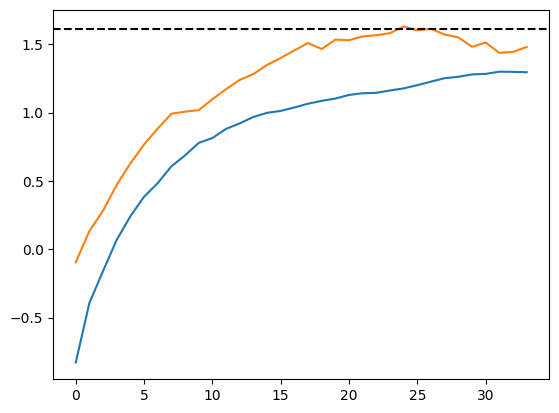

In [7]:
plt.plot(metrics[:e, 0])
plt.plot(metrics[:e, 1])
plt.axhline(log_F_true, linestyle="--", color="k")
plt.show()

In [8]:
# F, _ = get_F(d0_valid, f, (d0_valid, derivatives[:200]))
F, _ = get_F(fiducials, f, (fiducials[:len(derivatives)], derivatives))

a, b = jnp.linalg.slogdet(F)
log_F_f = a * b

(jnp.exp(log_F_true) / jnp.exp(log_F_f)).item()

1.345285177230835

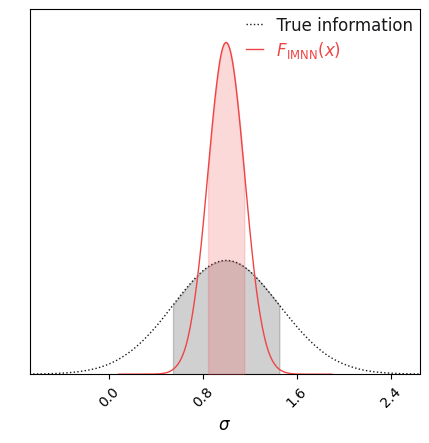

In [9]:
c = ChainConsumer()
c.add_chain(
    Chain.from_covariance(
        alpha,
        Finv_true,
        columns=parameter_names,
        name="True information",
        color="k",
        linestyle=":"
    )
)
c.add_chain(
    Chain.from_covariance(
        alpha,
        Finv,
        columns=parameter_names,
        name=r"$F_{\text{IMNN}}(x)$",
        color="r",
    )
)
fig = c.plotter.plot()